In [1]:
!nvidia-smi

Sun Mar 20 20:57:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install datasets transformers

     |████████████████████████████████| 325 kB 4.2 MB/s            
     |████████████████████████████████| 212 kB 60.2 MB/s            


In [3]:
!wget -O train_en.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/train_en.jsonl.bz2
!wget -O test_en.jsonl.bz2 https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/test_en.jsonl.bz2

!bzip2 -dk train_en.jsonl.bz2
!bzip2 -dk test_en.jsonl.bz2

!ls -l

--2022-03-20 20:57:22--  https://github.com/TurkuNLP/wikipedia-toxicity-data-fi/raw/main/train_en.jsonl.bz2
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TurkuNLP/wikipedia-toxicity-data-fi/main/train_en.jsonl.bz2 [following]
--2022-03-20 20:57:22--  https://raw.githubusercontent.com/TurkuNLP/wikipedia-toxicity-data-fi/main/train_en.jsonl.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21191431 (20M) [application/octet-stream]
Saving to: ‘train_en.jsonl.bz2’

train_en.jsonl.bz2  100%[===================>]  20.21M  --.-KB/s    in 0.1s    

2022-03-20 20:57:23 (143 MB/s) - ‘train_en.jsonl.bz

In [4]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

output_dir = "./results-base"
#output_dir = "./drive/MyDrive/utu/kandi/results1"
checkpoint_dir = None # "./results/checkpoint-15000"
#tokenizer_name = "bert-base-uncased"
tokenizer_name = "xlm-roberta-base"
# tokenizer_name = "TurkuNLP/bert-base-finnish-cased-v1"
labels = ["label_identity_attack", "label_insult", "label_obscene", "label_severe_toxicity", "label_threat", "label_toxicity"]

device

'cuda:0'

In [5]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("WANDB_API_KEY")

os.environ['WANDB_API_KEY'] = wandb_key

In [6]:
import numpy as np
from datasets import load_dataset, Dataset

dataset = load_dataset('json', data_files={'train': 'train_en.jsonl', 'test': 'test_en.jsonl'})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-e602d177d4ab8369/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'id': ['ee9697785fe41ff8', '29fec512f2ee929e', '88944b29dde50648', 'c7bf1f59096102f3', '7d71ee0e8ea0794a'], 'label_identity_attack': [0, 0, 0, 0, 0], 'label_insult': [0, 0, 0, 0, 0], 'label_obscene': [0, 0, 0, 0, 0], 'label_severe_toxicity': [0, 0, 0, 0, 0], 'label_threat': [0, 0, 0, 0, 0], 'label_toxicity': [0, 0, 0, 0, 0], 'lang': ['en-orig', 'en-orig', 'en-orig', 'en-orig', 'en-orig'], 'text': ['"\nThanks Xeno. -  • Talk • "', '2009 (UTC)\nFixed    03:36, 8 June', 'Question\nWhat was wrong with the repair I did?', "I agree myself now, actually. (Amazing how the deniars can't admit their mistakes!!)", 'Kisumu \n\nI saw that you contributed to Kisumu, I was wondering whether we could work together to update the Kisumu page which currently reads like a travel brochure, which is very undeserving for a leading town in East Africa. If possible could you constructively help me make it better, I am hoping to get together a work group of contributers to help out so that it is something clos

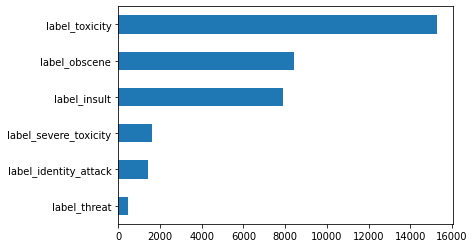

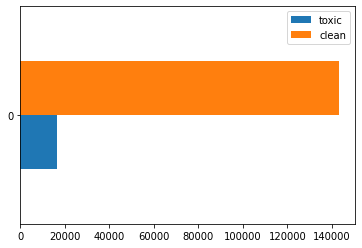

In [7]:
import pandas as pd

df_pandas = pd.DataFrame(dataset['train'])
df_pandas[labels].sum().sort_values().plot(kind="barh");

train_toxic = df_pandas[df_pandas[labels].sum(axis=1) > 0]
train_clean = df_pandas[df_pandas[labels].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');

train_df = df_pandas
#train_df = pd.concat([
#  train_toxic,
#  train_clean.sample(20_000, random_state=123)
#])
# shuffle
#train_df = train_df.sample(frac=1, random_state=123)

#dataset['train'] = Dataset.from_pandas(train_df)

print(dataset['train'][:5])
print(dataset)

In [8]:
print(len(train_toxic))
print(len(train_clean))

16225
143346


In [9]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

def preprocess(items):
    return tokenizer(items["text"], truncation=True, max_length=256, padding="max_length")

ds = dataset.remove_columns(["id", "lang"])
ds = ds.map(lambda it: {'labels': torch.FloatTensor([it[label] for label in labels])})
ds = ds.remove_columns(labels)
tokenized_data = ds.map(preprocess, batched=True)
tokenized_data = tokenized_data.remove_columns(["text"])

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

  0%|          | 0/159571 [00:00<?, ?ex/s]

  0%|          | 0/63978 [00:00<?, ?ex/s]

  0%|          | 0/160 [00:00<?, ?ba/s]

  0%|          | 0/64 [00:00<?, ?ba/s]

In [10]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
#tokenized_data['train'][0]

In [12]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback

model = None
if checkpoint_dir is not None:
  model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir)
else:
  model = AutoModelForSequenceClassification.from_pretrained(
                                                           tokenizer_name,
                                                           num_labels=len(labels),
                                                           problem_type="multi_label_classification",
                                                           id2label={int(i): v for i, v in enumerate(labels)},
                                                           label2id={str(v): i for i, v in enumerate(labels)},
                                                          )
# model = model.to(device)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [13]:
from sklearn.utils import class_weight

class_counts = [v for v in train_df[labels].sum()]
pos_weights = np.ones_like(class_counts)

neg_counts = [len(dataset['train']) - count for count in class_counts]
print("i", "pos.", "neg.")
for i, (pos, neg) in enumerate(zip(class_counts,  neg_counts)):
    print(i, pos, neg)
    pos_weights[i] = neg / pos

class_weights = pos_weights
class_weights

i pos. neg.
0 1405 158166
1 7877 151694
2 8449 151122
3 1595 157976
4 478 159093
5 15294 144277


array([112,  19,  17,  99, 332,   9])

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, hamming_loss
from scipy.special import expit as sigmoid
from torch import nn

def compute_metrics(pred):
    y_act = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred > 0.5).astype(float)
    
    print("-------- classification report --------")
    print(classification_report(y_act, y_pred, target_names=labels))
    print("-------- roc auc -------- ")
    
    roc_auc = roc_auc_score(y_act, y_pred, labels=labels, average="macro")
    print(roc_auc)
    print("-------- hamming_loss -------- ")
    print(hamming_loss(y_act, y_pred))
    print("-------- end --------")
    
    metrics = classification_report(y_act, y_pred, target_names=labels, output_dict=True)
    metrics["avg_f1"] = metrics["weighted avg"]["f1-score"]
    metrics['roc_auc'] = roc_auc
    metrics['hamming_l0ss'] = hamming_loss(y_act, y_pred)
    
    return metrics

class_weights = torch.tensor(class_weights).to(device)

class CustomTrainer(Trainer):
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs['logits']
        loss_func = nn.BCEWithLogitsLoss(pos_weight=class_weights)
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir=output_dir + "-2e-16b-trunc256-3e-xlm",
    learning_rate=2e-5,
    gradient_accumulation_steps=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3, # TODO
    weight_decay=0.01,
    evaluation_strategy="steps",
    warmup_steps=2000,
    eval_steps=2500, # 5000
    save_steps=2500,
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_avg_f1"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

if checkpoint_dir is not None:
    trainer.train(checkpoint_dir)
else:
    trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


***** Running training *****
  Num examples = 159571
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 2
  Total optimization steps = 14961
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: toppev (use `wandb login --relogin` to force relogin)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss,Validation Loss,Label Identity Attack,Label Insult,Label Obscene,Label Severe Toxicity,Label Threat,Label Toxicity,Micro avg,Macro avg,Weighted avg,Samples avg,Avg F1,Roc Auc,Hamming L0ss
2500,0.582300,0.474352,"{'precision': 0.08736135834588525, 'recall': 0.8960674157303371, 'f1-score': 0.15920149719276358, 'support': 712}","{'precision': 0.2820838627700127, 'recall': 0.9716953603735046, 'f1-score': 0.4372373949579832, 'support': 3427}","{'precision': 0.34204601076847774, 'recall': 0.9466269303711731, 'f1-score': 0.50251689918021, 'support': 3691}","{'precision': 0.07942794279427942, 'recall': 0.9836512261580381, 'f1-score': 0.14698697068403907, 'support': 367}","{'precision': 0.061386138613861385, 'recall': 0.8815165876777251, 'f1-score': 0.11477938907744523, 'support': 211}","{'precision': 0.3836871950415403, 'recall': 0.9555008210180624, 'f1-score': 0.5475159954836282, 'support': 6090}","{'precision': 0.2655961893054702, 'recall': 0.9537867292040282, 'f1-score': 0.41549232294702676, 'support': 14498}","{'precision': 0.20599875138900947, 'recall': 0.9391763902214735, 'f1-score': 0.31803969109601155, 'support': 14498}","{'precision': 0.3221238832016527, 'recall': 0.9537867292040282, 'f1-score': 0.4744853755847766, 'support': 14498}","{'precision': 0.049005126762324554, 'recall': 0.09130508403930519, 'f1-score': 0.06070639835293311, 'support': 14498}",0.474485,0.917202,0.101353
5000,0.407200,0.451979,"{'precision': 0.19716535433070867, 'recall': 0.8792134831460674, 'f1-score': 0.3220993053768974, 'support': 712}","{'precision': 0.3341508277130595, 'recall': 0.9541873358622702, 'f1-score': 0.4949670778778476, 'support': 3427}","{'precision': 0.3907012871726587, 'recall': 0.9539420211324844, 'f1-score': 0.5543572384476109, 'support': 3691}","{'precision': 0.09522532188841201, 'recall': 0.9673024523160763, 'f1-score': 0.17338217338217338, 'support': 367}","{'precision': 0.22946544980443284, 'recall': 0.8341232227488151, 'f1-score': 0.3599182004089979, 'support': 211}","{'precision': 0.47229639519359146, 'recall': 0.9293924466338259, 'f1-score': 0.626314042270665, 'support': 6090}","{'precision': 0.3538957661500052, 'recall': 0.9386122223755, 'f1-score': 0.5139943342776204, 'support': 14498}","{'precision': 0.2865007726838105, 'recall': 0.9196934936399233, 'f1-score': 0.42183967296069874, 'support': 14498}","{'precision': 0.39227790175066607, 'recall': 0.9386122223755, 'f1-score': 0.5466647788503085, 'support': 14498}","{'precision': 0.0566225890149739, 'recall': 0.08897016682818053, 'f1-score': 0.06646044949524268, 'support': 14498}",0.546665,0.925637,0.067039
7500,0.408300,0.371473,"{'precision': 0.27341772151898736, 'recall': 0.9101123595505618, 'f1-score': 0.4205061648280338, 'support': 712}","{'precision': 0.3542231378076548, 'recall': 0.9533119346367085, 'f1-score': 0.5165217391304349, 'support': 3427}","{'precision': 0.38442374350086655, 'recall': 0.9615280411812517, 'f1-score': 0.5492532693646985, 'support': 3691}","{'precision': 0.12008210742387958, 'recall': 0.9564032697547684, 'f1-score': 0.2133738601823708, 'support': 367}","{'precision': 0.2281134401972873, 'recall': 0.8767772511848341, 'f1-score': 0.36203522504892366, 'support': 211}","{'precision': 0.42877002999926833, 'recall': 0.9622331691297209, 'f1-score': 0.5932074707698538, 'support': 6090}","{'precision': 0.36258044263067024, 'recall': 0.9559939301972686, 'f1-score': 0.525756771109931, 'support': 14498}","{'precision': 0.298171696741324, 'recall': 0.9367276709063077, 'f1-score': 0.4424829548873859, 'support': 14498}","{'precision': 0.38149508209765387, 'recall': 0.9559939301972686, 'f1-score': 0.5424296691090719, 'support': 14498}","{'precision': 0.06243344066189419, 'recall': 0.09192951743828609, 'f1-score': 0.07132502077170556, 'support': 14498}",0.542430,0.934617,0.065137
10000,0.382300,0.390966,"{'precision': 0.3049010367577757, 'recall': 0.9087078651685393, 'f1-score': 0.4565984474241355, 'support': 712}","{'precision': 0.386238312155

***** Running Evaluation *****
  Num examples = 63978
  Batch size = 16


-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.09      0.90      0.16       712
         label_insult       0.28      0.97      0.44      3427
        label_obscene       0.34      0.95      0.50      3691
label_severe_toxicity       0.08      0.98      0.15       367
         label_threat       0.06      0.88      0.11       211
       label_toxicity       0.38      0.96      0.55      6090

            micro avg       0.27      0.95      0.42     14498
            macro avg       0.21      0.94      0.32     14498
         weighted avg       0.32      0.95      0.47     14498
          samples avg       0.05      0.09      0.06     14498

-------- roc auc -------- 
0.9172016504171073
-------- hamming_loss -------- 
0.10135254827180176
-------- end --------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.20      0.88      0.32       712
         label_insult       0.33      0.95      0.49      3427
        label_obscene       0.39      0.95      0.55      3691
label_severe_toxicity       0.10      0.97      0.17       367
         label_threat       0.23      0.83      0.36       211
       label_toxicity       0.47      0.93      0.63      6090

            micro avg       0.35      0.94      0.51     14498
            macro avg       0.29      0.92      0.42     14498
         weighted avg       0.39      0.94      0.55     14498
          samples avg       0.06      0.09      0.07     14498

-------- roc auc -------- 
0.9256365850867124
-------- hamming_loss -------- 
0.06703866954265529
-------- end --------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.27      0.91      0.42       712
         label_insult       0.35      0.95      0.52      3427
        label_obscene       0.38      0.96      0.55      3691
label_severe_toxicity       0.12      0.96      0.21       367
         label_threat       0.23      0.88      0.36       211
       label_toxicity       0.43      0.96      0.59      6090

            micro avg       0.36      0.96      0.53     14498
            macro avg       0.30      0.94      0.44     14498
         weighted avg       0.38      0.96      0.54     14498
          samples avg       0.06      0.09      0.07     14498

-------- roc auc -------- 
0.9346170304681666
-------- hamming_loss -------- 
0.06513697416820366
-------- end --------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.30      0.91      0.46       712
         label_insult       0.39      0.94      0.55      3427
        label_obscene       0.41      0.95      0.57      3691
label_severe_toxicity       0.12      0.97      0.22       367
         label_threat       0.26      0.91      0.41       211
       label_toxicity       0.47      0.95      0.63      6090

            micro avg       0.39      0.94      0.55     14498
            macro avg       0.33      0.94      0.47     14498
         weighted avg       0.42      0.94      0.57     14498
          samples avg       0.06      0.09      0.07     14498

-------- roc auc -------- 
0.9395007355739174
-------- hamming_loss -------- 
0.05733481300863839
-------- end --------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

-------- classification report --------
                       precision    recall  f1-score   support

label_identity_attack       0.32      0.89      0.47       712
         label_insult       0.44      0.91      0.60      3427
        label_obscene       0.47      0.91      0.62      3691
label_severe_toxicity       0.17      0.92      0.28       367
         label_threat       0.33      0.86      0.48       211
       label_toxicity       0.47      0.94      0.63      6090

            micro avg       0.43      0.92      0.59     14498
            macro avg       0.37      0.90      0.51     14498
         weighted avg       0.45      0.92      0.60     14498
          samples avg       0.07      0.09      0.07     14498

-------- roc auc -------- 
0.9279631264979088
-------- hamming_loss -------- 
0.04854793835380912
-------- end --------


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

In [15]:
# Test

In [16]:
#!zip -r ./checkpoint.zip ./results/checkpoint-12000